In [15]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from os import listdir
from os.path import isfile, join
import pymc3 as pm
import math as m
import arviz as az

import dive
import matplotlib.pyplot as plt
import deerlab as dl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
traces = []

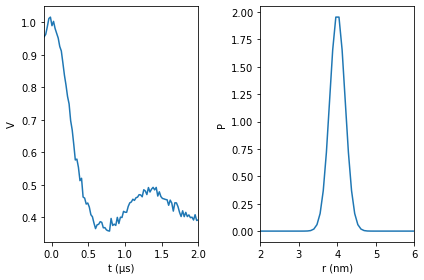

In [17]:
nr = 50
nt = 100

t = np.linspace(-0.1,2,nt)        # time axis, µs
r = np.linspace(2,6,nr)      # distance axis, ns
param = [4, 0.2] # parameters for three-Gaussian model
P0 = dl.dd_gauss(r,param)          # model distance distribution
lam = 0.5
k = 0.1
V0 = 1                      # modulation depth

B = dive.bg_exp(t,k)         # background decay
K = dive.dipolarkernel(t,r)    # kernel matrix

Vexp = dive.deerTrace(K@P0,B,V0,lam) + dl.whitegaussnoise(t,0.01,seed=0)

fig, ax = plt.subplots(1,2)
line1 = ax[0].plot(t, Vexp)
line2 = ax[1].plot(r, P0)

ax[0].set(xlim = [min(t),max(t)], xlabel = 't (µs)', ylabel = 'V')
ax[1].set(xlim = [2,6], xlabel = 'r (nm)', ylabel = 'P')
plt.tight_layout()
plt.show()

In [18]:
KtK = np.matmul(np.transpose(K),K)

S = np.matmul(K,P0)
KtS = np.matmul(np.transpose(K),S)

L = dl.regoperator(r,1)
LtL = np.matmul(np.transpose(L),L)

## First case: Pmap is equivalent to Ptrue

In [49]:
with pm.Model() as model:
    # Noise
    sigma = pm.Gamma('sigma', alpha=0.7, beta=2)

    #  Distribution model
    delta = pm.Gamma('delta', alpha=0.7, beta=2)

    tau = pm.Deterministic('tau',1/(sigma*sigma))

    P = dive.randP_p(delta,tau*KtK,tau*KtS,LtL,nr)    

    # Background
    k = pm.Gamma('k', alpha=0.5, beta=2)
    B = dive.bg_exp(t,k)

    # DEER Signal
    lamb = pm.Beta('lamb', alpha=1.3, beta=2.0)
    V0 = pm.Bound(pm.Normal,lower=0.0)('V0', mu=1, sigma=0.2)

    Vmodel = dive.deerTrace(pm.math.dot(K,P),B,V0,lamb)
    pm.Normal('V',mu = Vmodel, sigma = sigma, observed = Vexp)

pm.model_to_graphviz(model)

TypeError: any() got an unexpected keyword argument 'out'

In [6]:
trace = pm.sample(model = model,chains=3, cores=3, draws=5000, tune=1000,return_inferencedata=False)
traces.append(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [V0, lamb, k, P, delta, sigma]


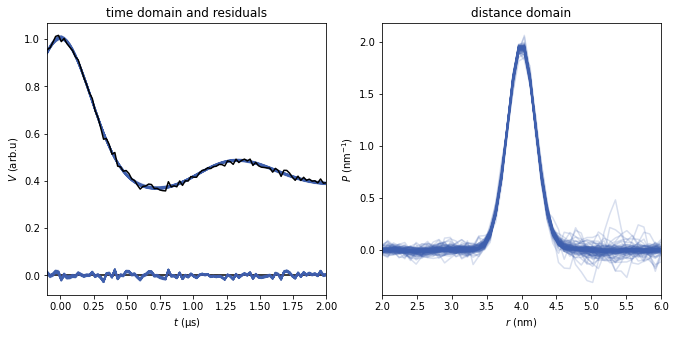

In [13]:
Ps, Vs, _, _ = dive.drawPosteriorSamples(traces[-1],r,t,100)
dive.plotMCMC(Ps,Vs,Vexp,t,r)

In [18]:
import numpy as np
X = np.array([[1, 4, -2], [0, 5, 3], [0, 0, 3]])
print(np.linalg.inv(X))
print(np.linalg.cholesky(X))


[[ 1.         -0.8         1.46666667]
 [ 0.          0.2        -0.2       ]
 [ 0.          0.          0.33333333]]
[[1.         0.         0.        ]
 [0.         2.23606798 0.        ]
 [0.         0.         1.73205081]]


In [19]:
np.random.standard_normal(size=(10,1))

array([[ 0.12082263],
       [-0.10975679],
       [-0.34441855],
       [-2.09742202],
       [ 0.13687917],
       [ 2.18819848],
       [-0.7195011 ],
       [-0.58231959],
       [ 1.53070369],
       [ 0.63521201]])

In [29]:
print(X)

v = np.array([-0.8314,-0.9792,-1.1564])
print(v)

Y = np.linalg.lstsq(np.matrix.transpose(X),v,rcond=None)

print(Y[0])

[[ 1  4 -2]
 [ 0  5  3]
 [ 0  0  3]]
[-0.8314 -0.9792 -1.1564]
[-0.8314      0.46928    -1.40901333]


In [23]:
from theano import tensor as tt
from theano import 

In [24]:
import theano as t
